In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ulh_dxs6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ulh_dxs6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 34.2 MB/s eta 0:00:00


In [ ]:
!pip install ftfy regex tqdm

In [ ]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
import pytorch_lightning as pl
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns
from torchvision.models import resnet18

In [ ]:
# ------------------ 1. Load STL-10 Dataset ------------------
transform = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


train_dataset = datasets.STL10(root="./data", split='train', transform=transform, download=True)
test_dataset = datasets.STL10(root="./data", split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

labels = train_dataset.classes  # STL-10 class labels

In [ ]:
# ------------------ 2. Tokenization using CLIP ------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

text_inputs = processor(text=labels, return_tensors="pt", padding=True)

with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)

text_embeddings = text_features.cpu().numpy()  # Ready for downstream use

In [ ]:

# ------------------ 3. PyTorch Lightning Model (ResNet-based) ------------------
class FineTuneResNet(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.feature_extractor = resnet18(weights="IMAGENET1K_V1")
        for param in self.feature_extractor.parameters():
          param.requires_grad = False
        self.feature_extractor.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
          )

        self.criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
        self.train_losses, self.val_losses = [], []
        self.train_accuracies, self.val_accuracies = [], []

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.train_losses.append(loss.item())
        self.train_accuracies.append(acc.item())

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.val_losses.append(loss.item())
        self.val_accuracies.append(acc.item())

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.0005, weight_decay=1e-3)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}


In [ ]:
# ------------------ 4. Train Model ------------------
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

model = FineTuneResNet(num_classes=len(labels))

trainer = pl.Trainer(
    min_epochs = 10,
    max_epochs=20,
    accelerator=device,
    log_every_n_steps=10,
    callbacks=[early_stop, checkpoint]
)

trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | feature_extractor | ResNet           | 11.2 M | train
1 | classifier        | Sequential       | 166 K  | train
2 | criterion         | CrossEntropyLoss | 0      | train
---------------------------------------------------------------
166 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.371    Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

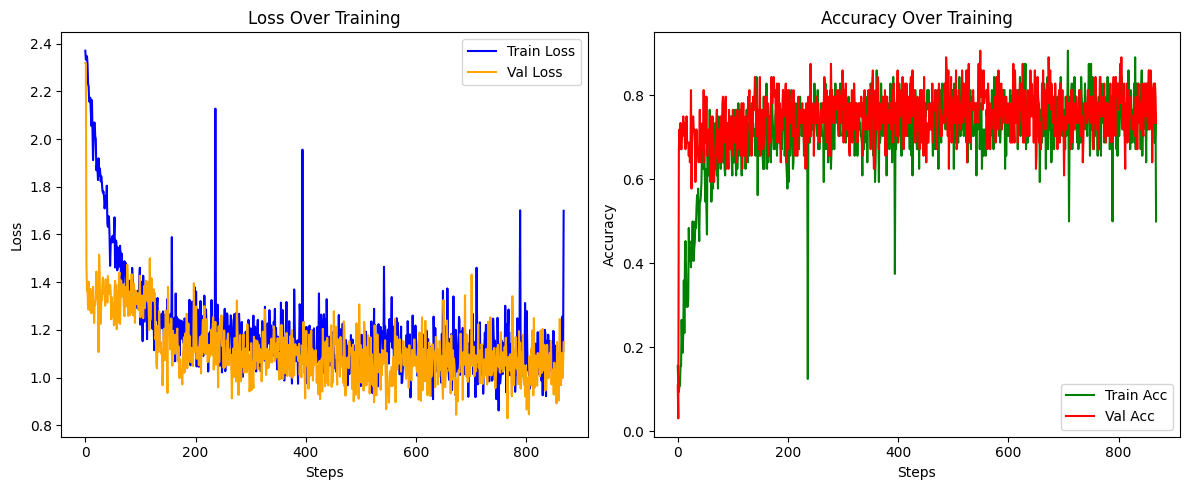

In [ ]:
# ------------------ 5. Plot Accuracy and Loss ------------------
def plot_metrics(model):
    steps = list(range(min(len(model.train_losses), len(model.val_losses))))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(steps, model.train_losses[:len(steps)], label='Train Loss', color='blue')
    plt.plot(steps, model.val_losses[:len(steps)], label='Val Loss', color='orange')
    plt.xlabel('Steps'); plt.ylabel('Loss'); plt.title('Loss Over Training'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(steps, model.train_accuracies[:len(steps)], label='Train Acc', color='green')
    plt.plot(steps, model.val_accuracies[:len(steps)], label='Val Acc', color='red')
    plt.xlabel('Steps'); plt.ylabel('Accuracy'); plt.title('Accuracy Over Training'); plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(model)


Test Accuracy: 76.79%
              precision    recall  f1-score   support

    airplane       0.81      0.81      0.81       800
        bird       0.84      0.78      0.81       800
         car       0.91      0.83      0.87       800
         cat       0.69      0.61      0.65       800
        deer       0.68      0.75      0.72       800
         dog       0.68      0.68      0.68       800
       horse       0.76      0.74      0.75       800
      monkey       0.76      0.77      0.76       800
        ship       0.79      0.90      0.84       800
       truck       0.76      0.81      0.79       800

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000


Confusion Matrix:


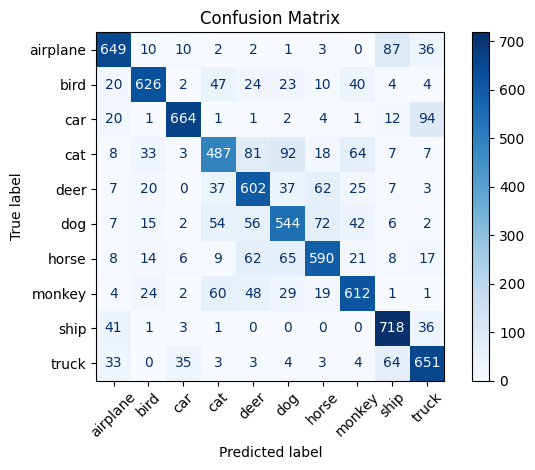

In [ ]:
# ------------------ 6. Evaluate on Test Set ------------------
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_loader, device=device)

Extracting features...
Running t-SNE...
Plotting...


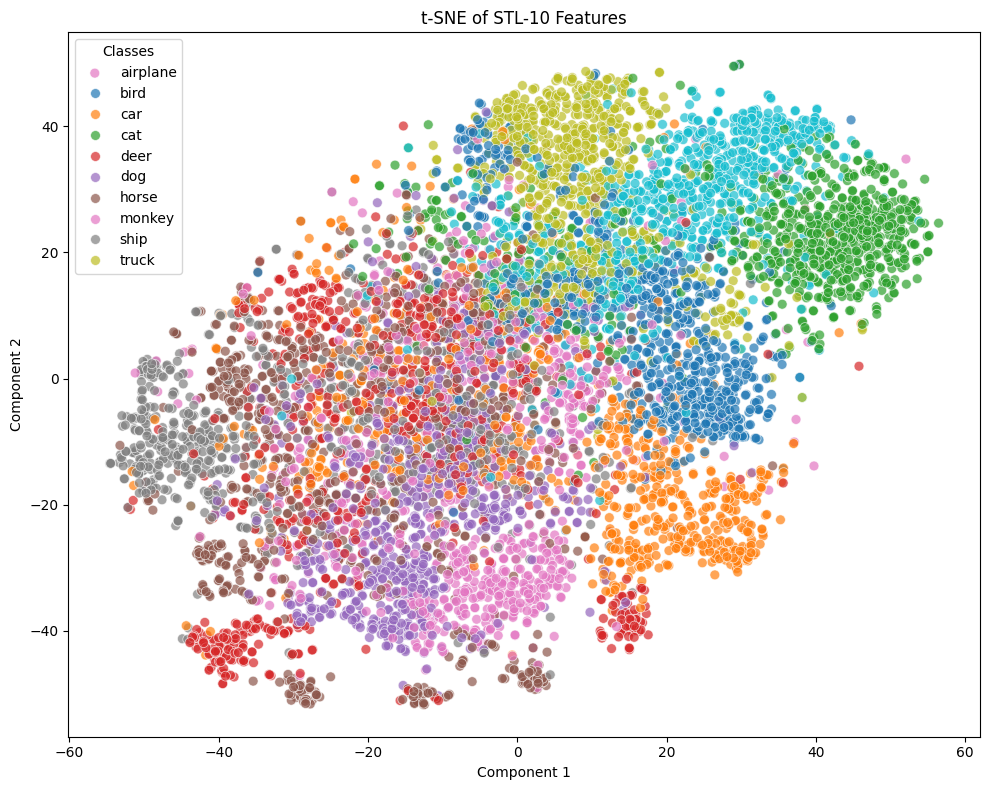

In [ ]:
# ------------------ 7. t-SNE Visualization ------------------
def extract_features(model, dataloader, device):
    model.to(device)
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = model.feature_extractor(imgs)
            features.append(feats.cpu().numpy())
            labels.extend(lbls.numpy())

    return np.concatenate(features, axis=0), np.array(labels)

def plot_tsne(model, dataloader, class_names, device="cuda"):
    print("Extracting features...")
    features, labels = extract_features(model, dataloader, device)

    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    print("Plotting...")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1],
                    hue=labels, palette="tab10", s=50, alpha=0.7, legend="full")
    plt.title("t-SNE of STL-10 Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Classes", loc="best", labels=class_names)
    plt.tight_layout()
    plt.show()

plot_tsne(model, test_loader, class_names=train_dataset.classes, device=device)
